# Threat Search Policy


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from domoku.tools import GomokuTools as Gt
from domoku import jupyter_tools as jt

from domoku.policies.threat_search import ThreatSearchPolicy

In [3]:
SIZE=15

In [4]:
policy = ThreatSearchPolicy(board_size=SIZE)

2022-06-26 02:23:22.736213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [10]:
examine = 'c11f9e9g8f7g7g9h8'
#examine = 'D7K7D10K10F7M11'

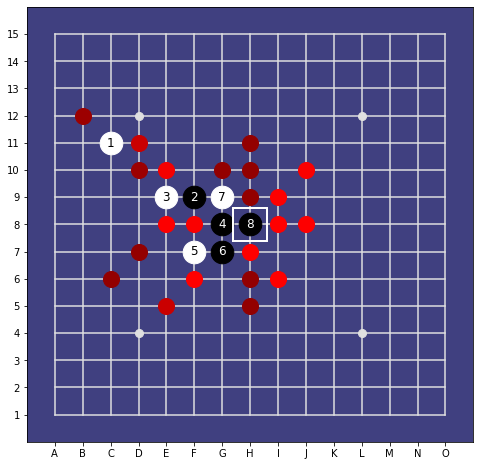

In [11]:
from domoku.board import GomokuBoard as LegacyBoard
stones = Gt.string_to_stones(examine)
board = LegacyBoard(n=SIZE, disp_width=8, stones=stones, heuristics=policy)
board.display()

In [12]:
import numpy as np
from alphazero.gomoku_board import GomokuBoard
board = GomokuBoard(SIZE, examine, x_means='b')
print(np.squeeze(500 * policy(board.canonical_representation())).astype(int))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 480   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 698   0   0   0 444   0   0   0   0   0   0   0]
 [  0   0   0 480 939   0 444 444   0 973   0   0   0   0   0]
 [  0   0   0   0   0   0   0 444 999   0   0   0   0   0   0]
 [  0   0   0   0 992 973   0   0 999 999   0   0   0   0   0]
 [  0   0   0 444   0   0   0 999   0   0   0   0   0   0   0]
 [  0   0 444   0   0 995   0 444 999   0   0   0   0   0   0]
 [  0   0   0   0 698   0   0 444   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [21]:
secondary_patterns = [
    [[-1, 1, -1, -1,   -1,   -1, -1, -1, -1],
     [-1, 0,  1, -1,   -1,   -1, -1, -1, -1]],

    [[-1,  1, -1, -1,  -1,   -1, -1, -1, -1],
     [-1,  0, -1,  1,  -1,   -1, -1, -1, -1]]]

In [22]:
p = secondary_patterns[0]
p

[[-1, 1, -1, -1, -1, -1, -1, -1, -1], [-1, 0, 1, -1, -1, -1, -1, -1, -1]]

In [67]:
import numpy as np
from domoku.policies.radial import hor_1xnxn, ver_1xnxn

def all_5xnxn(pattern, pov):
    stones, influence = pattern
    size = len(stones)
    center = size // 2
    none_here = -np.ones((size, size))
    dont_care = np.zeros((size, size))
    if pov == 0:
        raw_stack = np.stack([
            np.stack([hor_1xnxn(stones), none_here, none_here, hor_1xnxn(influence), dont_care]),
            np.stack([np.diag(stones), none_here, none_here, np.diag(influence), dont_care]),
            np.stack([ver_1xnxn(stones), none_here, none_here, ver_1xnxn(influence), dont_care]),
            np.stack([np.diag(stones)[::-1], none_here, none_here, np.diag(influence)[::-1], dont_care]),
        ])
        raw_stack[:, 3, center, center] = 1  # means: add result on top of existing influence value of the current player
    else:
        raw_stack = np.stack([
            np.stack([none_here, hor_1xnxn(stones), none_here, dont_care, hor_1xnxn(influence)]),
            np.stack([none_here, np.diag(stones), none_here, dont_care, np.diag(influence)]),
            np.stack([none_here, ver_1xnxn(stones), none_here, dont_care, ver_1xnxn(influence)]),
            np.stack([none_here, np.diag(stones)[::-1], none_here, dont_care, np.diag(influence)[::-1]]),
        ])
        raw_stack[:, 4, center, center] = 1  # means: add result on top of existing influence value of the other player

    return np.rollaxis(np.rollaxis(raw_stack, 1, 4), 0, 4)


In [72]:
from domoku.policies.radial import all_5xnxn

In [73]:
channel = 0
secondary_patterns = policy.secondary_patterns
all_res = np.stack([
    all_5xnxn(pattern, channel) for pattern in secondary_patterns
], axis=-1)

In [77]:
all_res.reshape((9, 9, 5, -1)).shape

(9, 9, 5, 144)

In [42]:
stones, influence = pattern
l = len(stones)
none_here = -np.ones((l, l))
dont_care = np.zeros((l, l))

np.stack([hor_1xnxn(stones), none_here, none_here, hor_1xnxn(influence), dont_care]),

(array([[[ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.]],
 
        [[-1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., 

In [38]:
pattern

[[-1, 1, -1, -1, -1, -1, -1, -1, -1], [-1, 0, 1, -1, -1, -1, -1, -1, -1]]

In [37]:
none_here.shape

(2, 2)

In [20]:
res = all_2xnxn(secondary_patterns)
res

ValueError: cannot reshape array of size 18 into shape (2,1)

In [7]:
from alphazero.gomoku_board import GomokuBoard
board = GomokuBoard(SIZE, examine, x_means='b')
board.plot()
board

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  X  .  .  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  X  O  X  .  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  O [O] .  .  .  .  .  .  .    
 7    .  .  .  .  .  X  O  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 5    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 4    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O


C11 F9 E9 G8 F7 G7 G9 H8

In [8]:
board.print_pi(policy, scale=.1)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 499   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 999   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [11]:
policy.summary()

Model: "threat_search_policy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  93184     
                                                                 
 conv2d_1 (Conv2D)           multiple                  257       
                                                                 
 conv2d_2 (Conv2D)           multiple                  10        
                                                                 
Total params: 93,451
Trainable params: 93,441
Non-trainable params: 10
_________________________________________________________________


In [10]:
policy.secondary_patterns

NameError: name 'policy' is not defined

In [8]:
board.act('E', 3)

B2 B6 C4 D4 D5 E2 B4 C5 E3

In [9]:
board.plot()

                             
 7    .  .  .  .  .  .  .    
 6    .  O  .  .  .  .  .    
 5    .  .  O  X  .  .  .    
 4    .  X  X  O  .  .  .    
 3    .  .  .  .  X  .  .    
 2    .  X  .  .  O  .  .    
 1    .  .  .  .  .  .  .    
                             
      A  B  C  D  E  F  G


In [10]:
sample = board.math_rep
jt.print_bin(sample, combine=True)

shape: (9, 9, 3)
[[3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 3]
 [3 0 1 0 0 0 0 0 3]
 [3 0 0 1 2 0 0 0 3]
 [3 0 2 2 1 0 0 0 3]
 [3 0 0 0 0 2 0 0 3]
 [3 0 2 0 0 1 0 0 3]
 [3 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3]]


In [11]:
from domoku.constants import BLACK

hard_policy = MaxCriticalityPolicy(board_size=SIZE, overconfidence=2.0)
params = MaxInfluencePolicyParams(
    board_size=SIZE,
    sigma=.8,
    iota=20,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)
soft_policy = MaxInfluencePolicy(params, criticality_model=None, pov=BLACK)

2022-06-11 19:14:53.935977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [12]:
board.print_pi(soft_policy)

[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  3 531 407  91   0   0   0]
 [  0   0 112   0   0   0   0]
 [  0   0   0   0   0   0   0]]


In [13]:
move = soft_policy.sample(sample, 1, board=board)[0]
move

C3

---

# A Complete Game!

The mixed policy puts stones next to each other until it recoginizes a double-open 3 and then finishes the game.
With this policy, we're able to create loads of short, yet somewhat meaningful trajectories for training.

In [14]:
SIZE = 15

In [15]:
hard_policy = MaxCriticalityPolicy(board_size=SIZE, overconfidence=5.0)
params = MaxInfluencePolicyParams(
    board_size=SIZE,
    sigma=.6,
    iota=200,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)
soft_policy = MaxInfluencePolicy(params, criticality_model=hard_policy, pov=BLACK)

In [16]:
board = GomokuBoard(SIZE, stones='H8')
sample = board.math_rep.copy()

In [31]:
move = soft_policy.sample(sample, 1, board=board)[0]
board.act(move)
sample = board.math_rep
winner = hard_policy.get_winner(sample)
board.plot()
if winner is not None:
    print("**********************************************************")
    print("")
    print(f"                      TERMINATED")
    print("")
    print("**********************************************************")
print("")
print(f"Board: {board}")

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  X  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  O  O  O  O  O  X  .  .  .  .    
 9    .  .  .  .  .  .  .  X  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  O  X  X  .  .  .  .  .  .    
 7    .  .  .  .  .  .  X  .  X  X  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  .  O  .  .  .  .    
 5    .  .  .  .  .  .  O  .  .  .  .  .  .  .  .    
 4    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O
********************************